In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Data Exploration

In [111]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')
greeks = pd.read_csv('./data/greeks.csv')

In [4]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


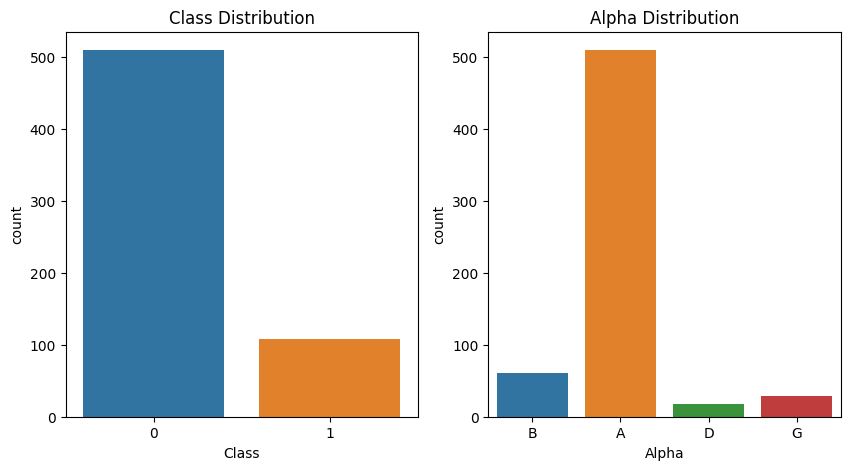

In [20]:
# look at the distribution of Class and Alpha
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='Class', data=train, ax=axes[0])
sns.countplot(x='Alpha', data=greeks, ax=axes[1])

axes[0].set_title('Class Distribution')
axes[1].set_title('Alpha Distribution')

plt.show()

As we can see, there is definitely an imbalance of classes (age-related symptoms vs not). We're going to see how accurate of a model we can get without using resampling or other methods to account for the imbalance first.

[]

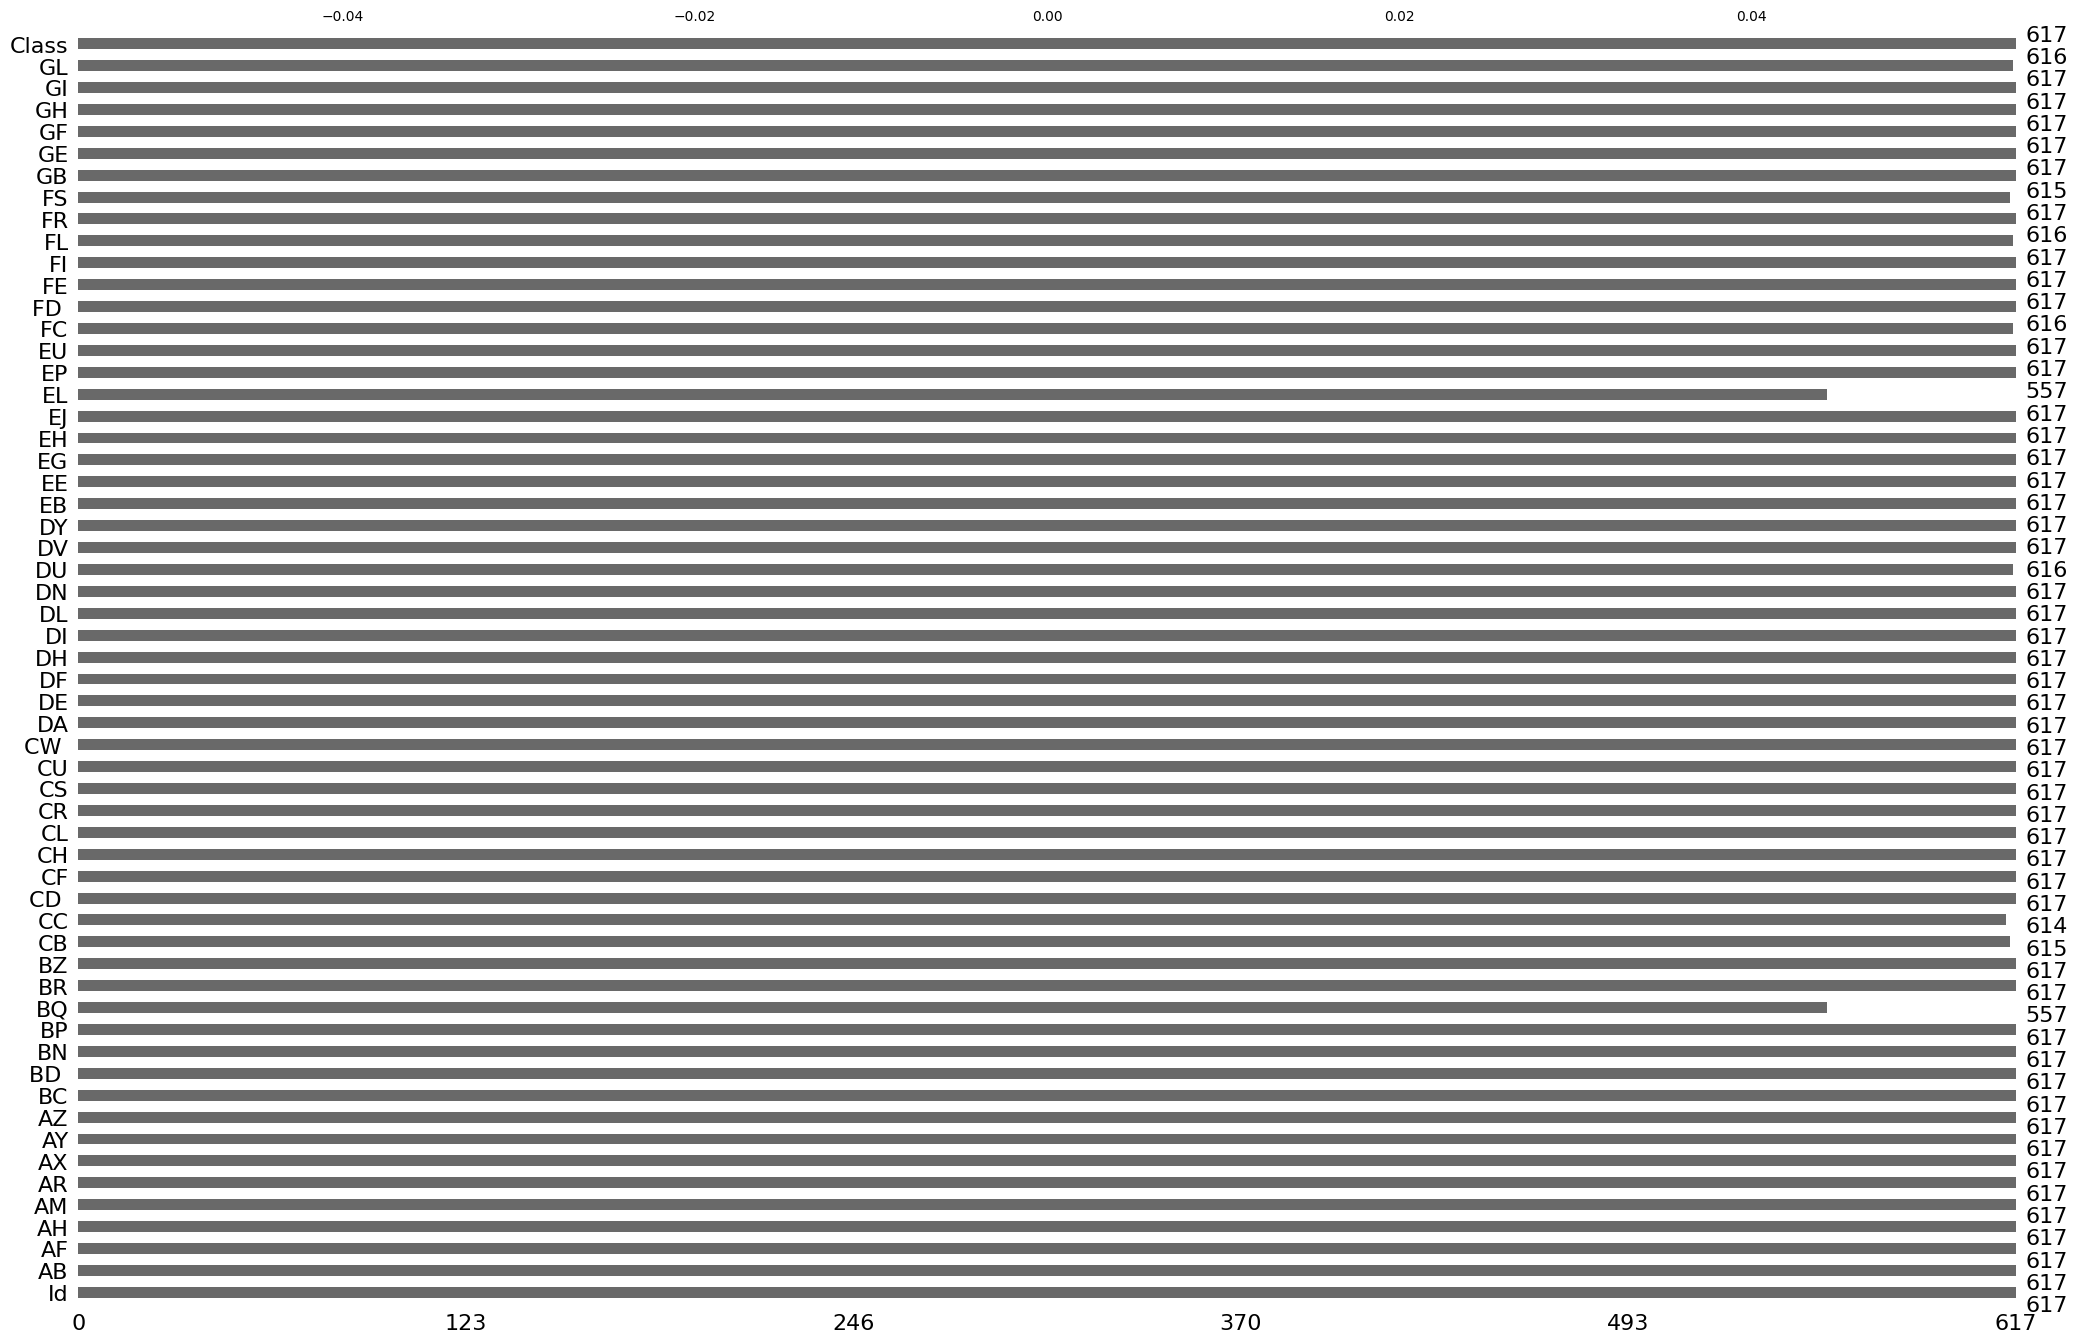

In [34]:
# check out missing data
msno.bar(train)
plt.plot()

In [37]:
train['Class'].value_counts()

Class
0    509
1    108
Name: count, dtype: int64

In [36]:
# make sure that we can drop the rows with missing values by checking that they aren't all of the positive class
rows_with_missing_values = train[train.isnull().any(axis=1)]
rows_with_missing_values['Class'].value_counts()

Class
0    63
1     6
Name: count, dtype: int64

We're just going to drop the rows with missing values, since it is relatively a small amount of the data and seems to be not to suspiciously distributed towards one class in comparison with the rest of the data.

# Data Prep
We'll make one model for each target variable to predict binarily, then predict for each row, and if any of the three are true then we predict true. We'll also test making a model using the overall y predictor (Class) as is

In [43]:
#drop the rows with missing values
new_train = train.dropna()

In [44]:
# create the four separate y vectors
y_b = (greeks.loc[greeks['Id'].isin(new_train['Id'])]['Alpha'] == 'B').astype(int)
y_d = (greeks.loc[greeks['Id'].isin(new_train['Id'])]['Alpha'] == 'D').astype(int)
y_g = (greeks.loc[greeks['Id'].isin(new_train['Id'])]['Alpha'] == 'G').astype(int)
y = new_train['Class']

In [45]:
# get predictor variables
X = new_train.drop(columns=['Id', 'Class'])

# one-hot encode categorical column
X = pd.get_dummies(X, columns=['EJ'])

# Modeling
Here we go through running through different grid searches to find the best model parameters for each of the y's.

In [65]:
# set up a random forest classifier grid search to use for the four y's
rfc = RandomForestClassifier(random_state=7)

rfc_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 2, 4, 8, 16, 32],
    'max_features': ['sqrt', 2, 4, 8, 16, 32]
    }

In [68]:
# find best random forest for y_b
rfc_gs_b = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=10, n_jobs=-1)
rfc_gs_b.fit(X, y_b)

print("best model accuracy: ", rfc_gs_b.best_score_)
print("best model params: ", rfc_gs_b.best_params_)

best model accuracy:  0.9562289562289564
best model params:  {'max_depth': 8, 'max_features': 32, 'n_estimators': 100}


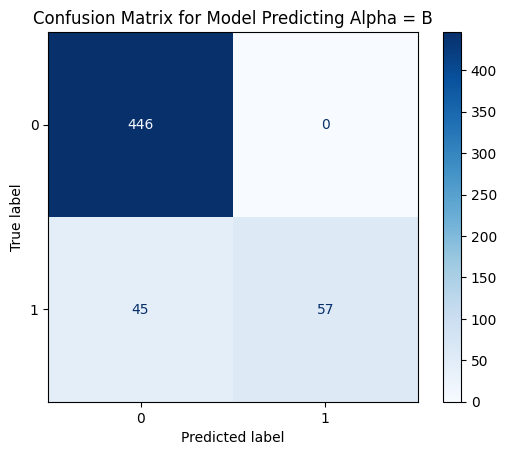

In [67]:
# get confusion matrix for y_b
y_b_pred = rfc_gs_b.predict(X)
cm = confusion_matrix(y, y_b_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model Predicting Alpha = B')
plt.show()

In [60]:
# find best random forest for y_d
rfc_gs_d = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=10, n_jobs=-1)
rfc_gs_d.fit(X, y_d)

print("best model accuracy: ", rfc_gs_d.best_score_)
print("best model params: ", rfc_gs_d.best_params_)

best model accuracy:  0.9799663299663299
best model params:  {'max_depth': 4, 'max_features': 32, 'n_estimators': 200}


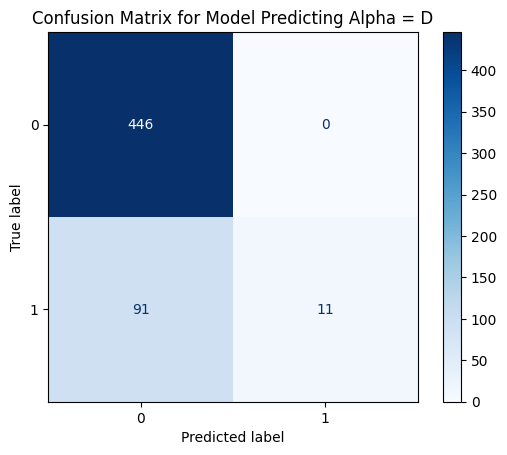

In [61]:
# get confusion matrix for y_d
y_d_pred = rfc_gs_d.predict(X)
cm = confusion_matrix(y, y_d_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model Predicting Alpha = D')
plt.show()

In [69]:
# finding best model for y_g
rfc_gs_g = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=10, n_jobs=-1)
rfc_gs_g.fit(X, y_g)

print("best model accuracy: ", rfc_gs_g.best_score_)
print("best model params: ", rfc_gs_g.best_params_)

best model accuracy:  0.9635353535353536
best model params:  {'max_depth': None, 'max_features': 32, 'n_estimators': 150}


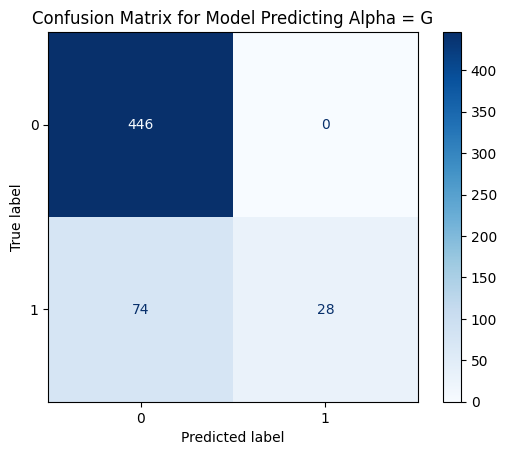

In [70]:
# get confusion matrix for y_g
y_g_pred = rfc_gs_g.predict(X)
cm = confusion_matrix(y, y_g_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model Predicting Alpha = G')
plt.show()

In [71]:
# check how model just predicting overall does
rfc_gs = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=10, n_jobs=-1)
rfc_gs.fit(X, y)

print("best model accuracy: ", rfc_gs.best_score_)
print("best model params: ", rfc_gs.best_params_)

best model accuracy:  0.9234006734006733
best model params:  {'max_depth': None, 'max_features': 32, 'n_estimators': 50}


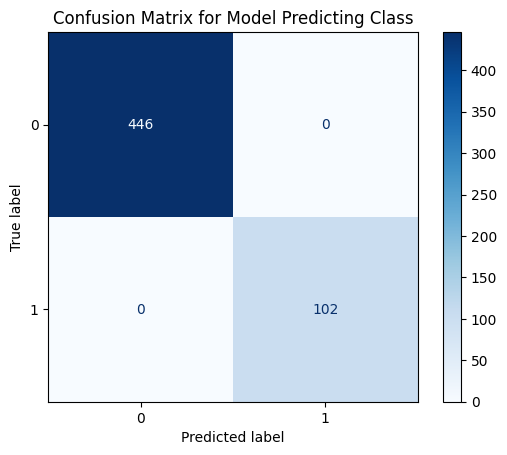

In [72]:
# get confusion matrix for y
y_pred = rfc_gs.predict(X)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model Predicting Class')
plt.show()

This is potentially good, but no mistakes means it is probably overfit, so we should go back and create a train/test split to double check our work (in case cross-validated prediction isn't working how I thought).

# Testing
Now we will test just using our main model (instead of agglomerating the 3 sub models) since it had the best performance.

In [113]:
test['EJ']

0    A
1    A
2    A
3    A
4    A
Name: EJ, dtype: object

Note: All of the test subjects have EJ = A

In [114]:
# Make the columns consistent between train and test data for prediction
X_test = test.drop(columns=['Id', 'EJ'])


In [115]:
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
X_test = X_test.assign(EJ_A=True, EJ_B=False)

In [117]:
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False


In [118]:
preds = rfc_gs.predict_proba(X_test)

In [120]:
output_preds = pd.DataFrame({'Id': test['Id'], 'class_0': preds[:,0], 'class_1': preds[:,1]})

In [121]:
output_preds.to_csv('./data/submission.csv', index=False)